In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from matplotlib.cm import get_cmap
sns.set_style('whitegrid')
from tqdm.auto import tqdm, trange

# Functions

In [ ]:
# Get homology representatives (cycles) based on list of connected edges
def get_cycles(cycles):

    new_cycle_flag = True
    cycles_list = []
    cur_cycle = set()

    for a, b in cycles:
        if new_cycle_flag:
            cur_cycle.update([a])
            cur_cycle.update([b])
            cycles_list.append([])
            new_cycle_flag = False
            continue

        if a in cur_cycle:
            cur_cycle.remove(a)
            cycles_list[-1].append(a)
        else:
            cur_cycle.update([a])

        if b in cur_cycle:
            cur_cycle.remove(b)
            cycles_list[-1].append(b)
        else:
            cur_cycle.update([b])

        if len(cur_cycle) == 0:
            new_cycle_flag = True

    return cycles_list

In [ ]:
# Get cycles for each space part
def get_holes_per_chunk(dir="holes/", filenames="ru_word_holes_norm_*.npy"):

  cycles = {}

  for file in glob.glob(f"{dir}/{filenames}"):
        cycles["_".join(file.split('_')[4:])[:-4]] = get_cycles(np.load(file) - 1) # !attention to filenames!

  return cycles

In [ ]:
def get_homology_birth_death(files):
    h_bd = {}

    for fn in files:
        chunk_num = "_".join(fn.split('_')[2:])[:-4]
        h_bd[chunk_num] = np.load(fn)

    h_all = np.hstack(list(h_bd.values()))
    h_lifetimes = np.diff(h_all, axis=0)

    return h_all, h_lifetimes, h_bd

In [ ]:
# Merge all homologies from different chunks and plot diagram
def collect_holes_from_chunks(dir="holes/"):

    h0_all, h0_lifetimes, h0_bd = get_homology_birth_death(glob.glob(f"{dir}/h0_norm_*.npy"))
    h1_all, h1_lifetimes, h1_bd = get_homology_birth_death(glob.glob(f"{dir}/h1_norm_*.npy"))

    plt.figure(figsize=(10, 8))

    # lifetimes
    h0_lifetime = h0_all[1] - h0_all[0]
    h1_lifetime = h1_all[1] - h1_all[0]

    sc0 = plt.scatter(h0_all[0], h0_all[1], s=10, alpha=0.5, c=h0_lifetime, cmap='viridis', marker='s', label='$H_0$')
    sc1 = plt.scatter(h1_all[0], h1_all[1], s=10, alpha=0.5, c=h1_lifetime, cmap='viridis', marker='o', label='$H_1$')

    # Colorbar for both
    plt.colorbar(sc1, label='lifetime')

    # Diagonal for h1
    plt.plot([h1_all[0].min(), h1_all[1].max()],
             [h1_all[0].min(), h1_all[1].max()],
             'r--', linewidth=2, alpha=0.8, label='$H_1$ birth=death')

    plt.xlabel('birth')
    plt.ylabel('death')
    plt.title('Persistence diagram ($H_0$ and $H_1$)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    return (h0_all, h0_lifetimes, h0_bd), (h1_all, h1_lifetimes, h1_bd)

In [ ]:
from scipy.spatial.distance import pdist, squareform

# Get hole diameters using files from space partition
def get_hole_diam(filtered_by_lifetime, h1_contours, lang='ru', part='word'):
    hole_diam = {}

    for n_chunk in tqdm(filtered_by_lifetime):
        if filtered_by_lifetime[n_chunk] == -1: continue
        hole_diam[n_chunk] = []
        chunk_emb = np.load(f'partition/{lang}_{part}_norm_{n_chunk}.npy') # !attention to filenames!
        chunk_pdist = squareform(pdist(chunk_emb, metric='cosine'))
        cycles_list = h1_contours[n_chunk][filtered_by_lifetime[n_chunk]:] # list of cycles of holes, filtered by lifetime (in one chunk)

        for edges in cycles_list:
            hole_diam[n_chunk].append(chunk_pdist[edges][:,edges].max())
    return hole_diam

In [ ]:
# Save first indices beginning from which holes are more persistent
def filter_by_lifetimes(h1_lifetimes, h1_bd, h1_contours, q=.99):
    q = np.quantile(h1_lifetimes, q=.99)
    filtered_by_lifetime = {}

    for n_chunk in h1_bd:
        if n_chunk not in h1_contours: continue

        chunk_n_holes = len(h1_contours[n_chunk])
        idx = np.where(np.diff(h1_bd[n_chunk], axis=0)[0][-chunk_n_holes:] > q)[0]
        filtered_by_lifetime[n_chunk] = idx[0] if len(idx) else -1

    return filtered_by_lifetime

In [ ]:
# save first indices beginning from which holes are more persistent
def filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.99):
    q_ = np.quantile(np.hstack(list(hole_diam.values())), q=q)
    filtered_by_hole_diam = {}

    for n_chunk in hole_diam:
        idx = np.where(hole_diam[n_chunk] > q_)[0]

        if len(idx):
            filtered_by_hole_diam[n_chunk] = idx + filtered_by_lifetime[n_chunk]

    return filtered_by_hole_diam

In [ ]:
def words_on_contour(filtered_holes, words, word_partition):
  for c in filtered_holes:
    cluster_idx = np.where(word_partition == c)[0]
    print(f"\nCluster {c}:")
    print('*' * 20)

    # Skip if no words in this cluster
    if len(cluster_idx) == 0:
        print(f"No words found in cluster {c}")
        continue

    for hole_num in filtered_holes[c]:
        try:
            # Contour indices (may be a list)
            contour_indices = h1_contours[c][hole_num]

            # Both single index and list cases
            if isinstance(contour_indices, (list, np.ndarray)):
                words_in_hole = []
                for idx in contour_indices:
                    if 0 <= idx < len(cluster_idx):
                        word = words[cluster_idx[idx]]
                        words_in_hole.append(word.tolist() if hasattr(word, 'tolist') else word)
                    else:
                        print(f"Index {idx} out of bounds for cluster {c}")
                print(f"Hole {hole_num}: {words_in_hole}")
            else:
                # Single index case
                if 0 <= contour_indices < len(cluster_idx):
                    word = words[cluster_idx[contour_indices]]
                    print(f"Hole {hole_num}: {word.tolist() if hasattr(word, 'tolist') else word}")
                else:
                    print(f"Index {contour_indices} out of bounds for cluster {c}")

        except Exception as e:
            print(f"Error processing hole {hole_num} in cluster {c}: {str(e)}")

# Ru words

## Collect holes

In [ ]:
# For all chunks get hole contours from hole indices
h1_contours = get_holes_per_chunk("holes/", "ru_word_holes_norm_*.npy")

In [ ]:
print([(cn, len(h1_contours[cn]))for cn in h1_contours])

[('5', 500), ('4', 500), ('0', 500), ('7', 500), ('6', 500), ('1', 500), ('3', 500), ('2', 500), ('9', 500), ('8', 500)]


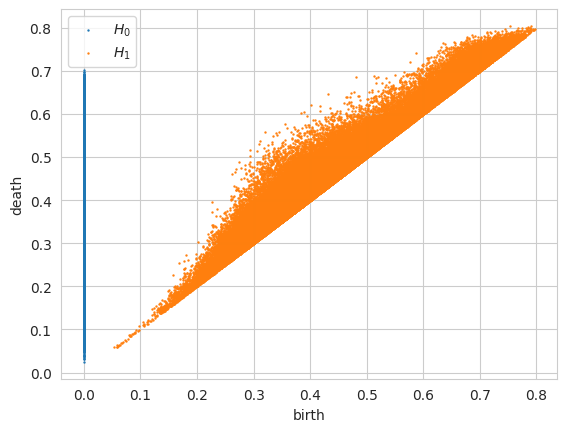

In [ ]:
# For all chunks get features
(h0_all, h0_lifetimes, h0_bd), (h1_all, h1_lifetimes, h1_bd) = collect_holes_from_chunks("holes/")

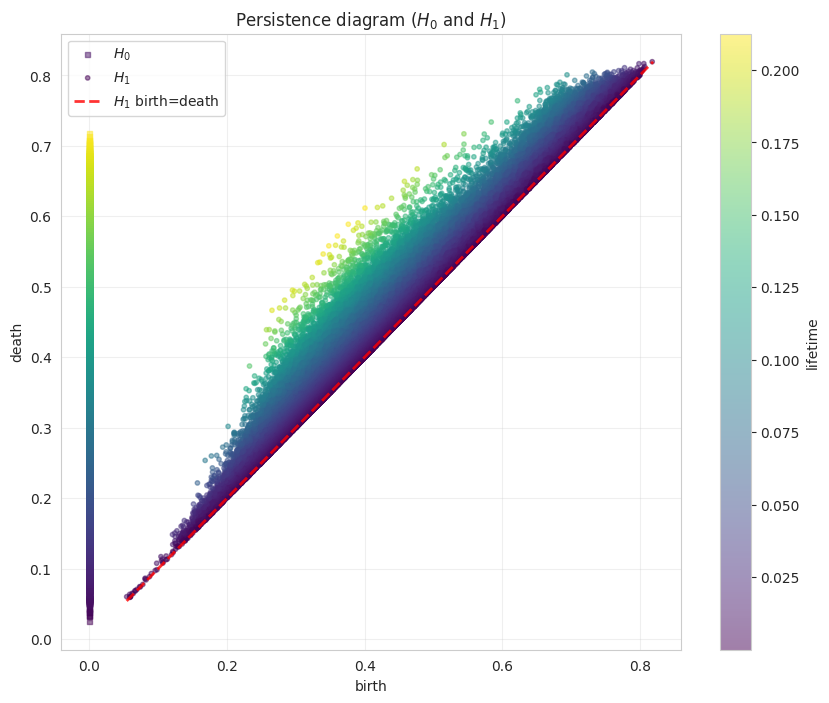

In [ ]:
# For all chunks get features and plot the persistence diagram
(h0_all, h0_lifetimes, h0_bd), (h1_all, h1_lifetimes, h1_bd) = collect_holes_from_chunks("holes/")

In [ ]:
h0_all.shape, h1_all.shape

((2, 72111), (2, 128589))

## Filter by lifetime

In [ ]:
filtered_by_lifetime = filter_by_lifetimes(h1_lifetimes, h1_bd, h1_contours)
np.save("holes/ru_word_filtered_by_lifetimes.npy", filtered_by_lifetime)
filtered_by_lifetime

{'2': np.int64(445),
 '6': np.int64(455),
 '4': np.int64(401),
 '1': np.int64(453),
 '7': np.int64(491),
 '5': -1,
 '3': np.int64(0),
 '8': -1,
 '0': np.int64(217),
 '9': np.int64(463)}

In [ ]:
sum(v for v in filtered_by_lifetime.values() if v not in {-1, 0})

np.int64(2925)

## Filter by hole diameter

In [ ]:
hole_diam = get_hole_diam(filtered_by_lifetime, h1_contours, lang='ru', part='word')
np.save("holes/ru_word_hole_diams.npy", hole_diam)

  0%|          | 0/10 [00:00<?, ?it/s]

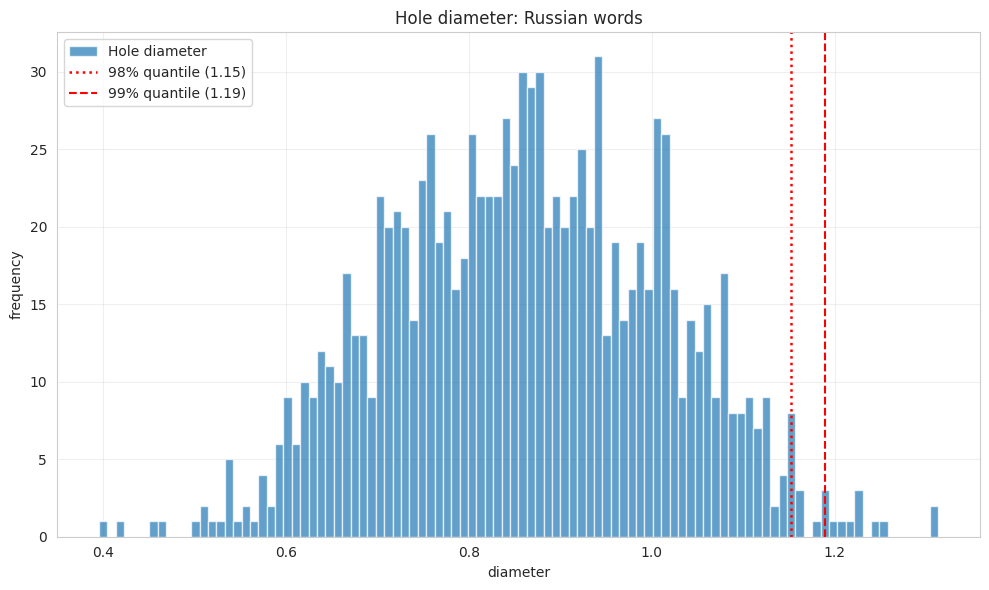

In [ ]:
# Diameters distribution
plt.figure(figsize=(10, 6))

diameters = np.hstack(list(hole_diam.values()))
q98 = np.quantile(diameters, 0.98)
q99 = np.quantile(diameters, 0.99)

plt.hist(diameters, bins=100, alpha=0.7, label='Hole diameter')

# Quantile lines
plt.axvline(q98, color='r', linestyle=':', linewidth=1.8, label=f'98% quantile ({q98:.2f})')
plt.axvline(q99, color='r', linestyle='--', linewidth=1.5, label=f'99% quantile ({q99:.2f})')

plt.xlabel('diameter')
plt.ylabel('frequency')
plt.title('Hole diameter: Russian words')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
filtered_by_hole_diam_98 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.98)
np.save("holes/ru_word_filtered_by_lifetimes_diam_98.npy", filtered_by_hole_diam_98)
filtered_by_hole_diam_98

{'3': array([ 21, 231, 281, 384, 389, 403, 405, 416, 417, 429, 434, 443, 445,
        458, 463, 474, 476, 484, 487, 492, 499]),
 '0': array([243])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_98.values())

22

In [ ]:
filtered_by_hole_diam_99 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.99)
np.save("holes/ru_word_filtered_by_lifetimes_diam_99.npy", filtered_by_hole_diam_99)
filtered_by_hole_diam_99

{'3': array([281, 384, 389, 403, 443, 445, 458, 463, 476, 492, 499])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_99.values())

11

In [ ]:
filtered_by_hole_diam_995 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.995)
np.save("holes/ru_word_filtered_by_lifetimes_diam_995.npy", filtered_by_hole_diam_995)
filtered_by_hole_diam_995

{'3': array([281, 389, 403, 443, 463, 499])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_995.values())

6

In [ ]:
!ls holes

h0_norm_0.npy  h1_norm_7.npy
h0_norm_1.npy  h1_norm_8.npy
h0_norm_2.npy  h1_norm_9.npy
h0_norm_3.npy  ru_word_filtered_by_lifetimes_diam_98.npy
h0_norm_4.npy  ru_word_filtered_by_lifetimes_diam_99.npy
h0_norm_5.npy  ru_word_filtered_by_lifetimes.npy
h0_norm_6.npy  ru_word_hole_diams.npy
h0_norm_7.npy  ru_word_holes_norm_0.npy
h0_norm_8.npy  ru_word_holes_norm_1.npy
h0_norm_9.npy  ru_word_holes_norm_2.npy
h1_norm_0.npy  ru_word_holes_norm_3.npy
h1_norm_1.npy  ru_word_holes_norm_4.npy
h1_norm_2.npy  ru_word_holes_norm_5.npy
h1_norm_3.npy  ru_word_holes_norm_6.npy
h1_norm_4.npy  ru_word_holes_norm_7.npy
h1_norm_5.npy  ru_word_holes_norm_8.npy
h1_norm_6.npy  ru_word_holes_norm_9.npy


## Hole contours in words

In [ ]:
word_dictionary = np.load("ru_cbow_normalized_dict.npy", allow_pickle=True).item()
words = list(word_dictionary.keys())
word_partition = np.load('partition/ru_word_partition_norm.npy')

In [ ]:
words_on_contour(filtered_by_hole_diam_98, words, word_partition)


Cluster 3:
********************
Hole 21: ['директор', 'викторович', 'здравствовать', 'широкодонный', 'кочедыжник', 'добор', 'вальцовочный']
Hole 231: ['присутствующий', 'присутствовать', 'состояться', 'обручение', 'обручать', 'незаконнорожденный', 'чистокровный', 'необученный', 'семеро', 'четверо', 'остальной']
Hole 281: ['подельник', 'напарник', 'напарница', 'куратор', 'преподаватель', 'ученица', 'воспитанница', 'фрейлина', 'герцогиня', 'герцог', 'канцлер', 'генерал', 'комиссар', 'следователь', 'полиция', 'милиция', 'мент', 'бандит']
Hole 384: ['бездельничать', 'развлекаться', 'веселиться', 'дурачиться', 'поддразнивать', 'ревновать', 'ревность', 'обида', 'горечь', 'тоска', 'скука', 'безделье']
Hole 389: ['телохранитель', 'гвардеец', 'оруженосец', 'рыцарь', 'воин', 'орк', 'вожак', 'волк', 'волчонок', 'котенок', 'малыш', 'сестренка', 'дочурка', 'внучка', 'племянница', 'баронесса', 'цесаревна', 'михайлович', 'генерал', 'майор', 'комиссар', 'инспектор', 'охранник', 'констебль']
Hole 403:

In [ ]:
words_on_contour(filtered_by_hole_diam_99, words, word_partition)


Cluster 3:
********************
Hole 281: ['подельник', 'напарник', 'напарница', 'куратор', 'преподаватель', 'ученица', 'воспитанница', 'фрейлина', 'герцогиня', 'герцог', 'канцлер', 'генерал', 'комиссар', 'следователь', 'полиция', 'милиция', 'мент', 'бандит']
Hole 384: ['бездельничать', 'развлекаться', 'веселиться', 'дурачиться', 'поддразнивать', 'ревновать', 'ревность', 'обида', 'горечь', 'тоска', 'скука', 'безделье']
Hole 389: ['телохранитель', 'гвардеец', 'оруженосец', 'рыцарь', 'воин', 'орк', 'вожак', 'волк', 'волчонок', 'котенок', 'малыш', 'сестренка', 'дочурка', 'внучка', 'племянница', 'баронесса', 'цесаревна', 'михайлович', 'генерал', 'майор', 'комиссар', 'инспектор', 'охранник', 'констебль']
Hole 403: ['резиденция', 'герцогство', 'вассал', 'сенешаль', 'мажордом', 'домоправительница', 'сиделка', 'санитарка', 'ординаторская', 'кабинет', 'апартамент']
Hole 443: ['оборотень', 'перевертыш', 'полукровка', 'эльф', 'чародейка', 'маг', 'колдун', 'демон', 'нежить', 'упырь', 'вурдалак', 

In [ ]:
words_on_contour(filtered_by_hole_diam_995, words, word_partition)


Cluster 3:
********************
Hole 281: ['подельник', 'напарник', 'напарница', 'куратор', 'преподаватель', 'ученица', 'воспитанница', 'фрейлина', 'герцогиня', 'герцог', 'канцлер', 'генерал', 'комиссар', 'следователь', 'полиция', 'милиция', 'мент', 'бандит']
Hole 389: ['телохранитель', 'гвардеец', 'оруженосец', 'рыцарь', 'воин', 'орк', 'вожак', 'волк', 'волчонок', 'котенок', 'малыш', 'сестренка', 'дочурка', 'внучка', 'племянница', 'баронесса', 'цесаревна', 'михайлович', 'генерал', 'майор', 'комиссар', 'инспектор', 'охранник', 'констебль']
Hole 403: ['резиденция', 'герцогство', 'вассал', 'сенешаль', 'мажордом', 'домоправительница', 'сиделка', 'санитарка', 'ординаторская', 'кабинет', 'апартамент']
Hole 443: ['оборотень', 'перевертыш', 'полукровка', 'эльф', 'чародейка', 'маг', 'колдун', 'демон', 'нежить', 'упырь', 'вурдалак', 'хвостатый', 'клыкастый', 'оскаливаться', 'ухмыляться', 'хохотнуть', 'захихикать', 'хихикать', 'смеяться', 'дурачиться', 'кривляться', 'корчить', 'скорчить', 'рожи

# Slv words

## Collect holes

In [ ]:
# For all chunks get hole contours from hole indices
h1_contours = get_holes_per_chunk("holes/", "slv_word_holes_norm_*.npy")

In [ ]:
print([(cn, len(h1_contours[cn]))for cn in h1_contours])

[('2', 500), ('6', 500), ('9b', 500), ('3', 500), ('7', 500), ('0', 500), ('5', 500), ('1', 500), ('4', 500), ('8', 500), ('9a', 500)]


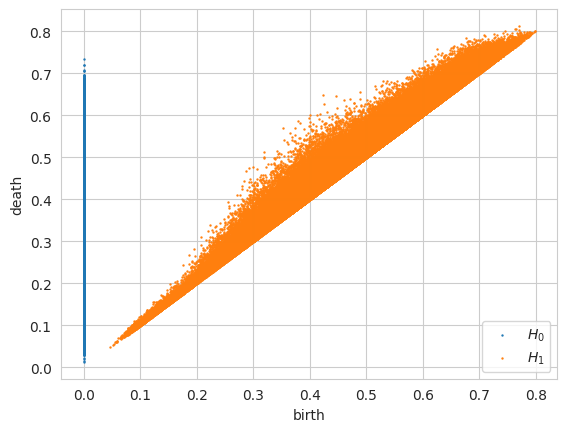

In [ ]:
(h0_all, h0_lifetimes, h0_bd), (h1_all, h1_lifetimes, h1_bd) = collect_holes_from_chunks("holes/")

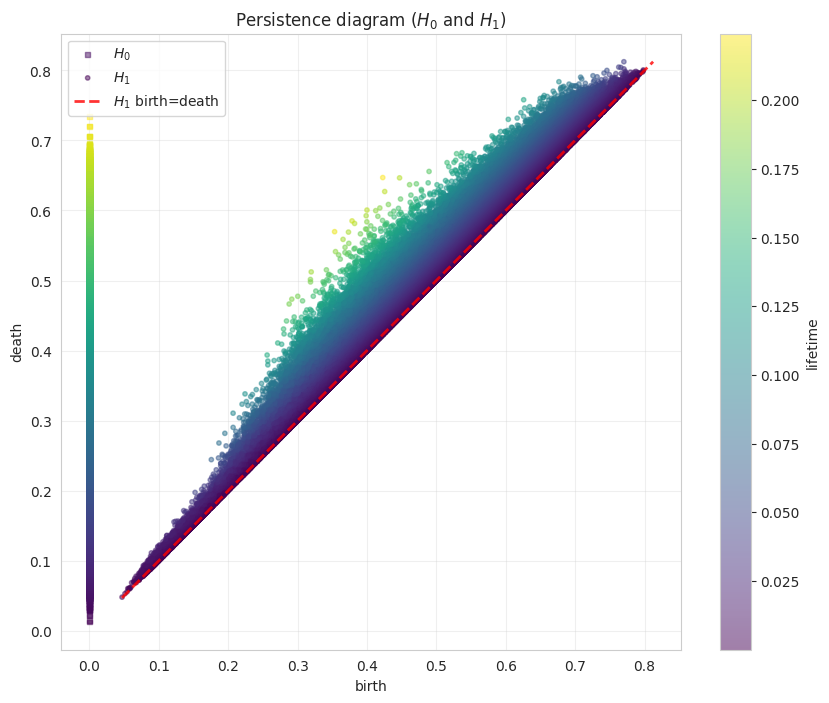

In [ ]:
# For all chunks get features and plot the persistence diagram
(h0_all, h0_lifetimes, h0_bd), (h1_all, h1_lifetimes, h1_bd) = collect_holes_from_chunks("holes/")

In [ ]:
h0_all.shape, h1_all.shape

((2, 122442), (2, 291268))

## Filter by lifetime

In [ ]:
filtered_by_lifetime = filter_by_lifetimes(h1_lifetimes, h1_bd, h1_contours)
np.save("holes/slv_word_filtered_by_lifetimes.npy", filtered_by_lifetime)
filtered_by_lifetime

{'2': -1,
 '6': np.int64(373),
 '4': np.int64(416),
 '9a': -1,
 '9b': np.int64(491),
 '1': np.int64(288),
 '7': np.int64(434),
 '5': np.int64(0),
 '3': np.int64(109),
 '8': np.int64(495),
 '0': np.int64(0)}

In [ ]:
sum(v for v in filtered_by_lifetime.values() if v not in {-1, 0})

np.int64(2606)

## Filter by hole diameter

In [ ]:
hole_diam = get_hole_diam(filtered_by_lifetime, h1_contours, lang='slv', part='word')
np.save("holes/slv_word_hole_diams.npy", hole_diam)

  0%|          | 0/11 [00:00<?, ?it/s]

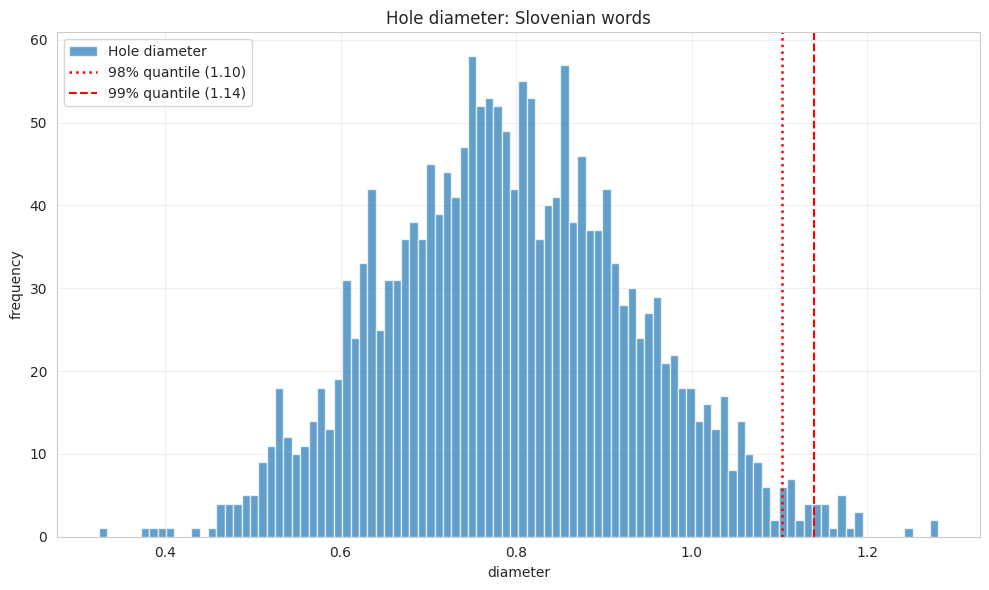

In [ ]:
# Diameters distribution
plt.figure(figsize=(10, 6))

diameters = np.hstack(list(hole_diam.values()))
q98 = np.quantile(diameters, 0.98)
q99 = np.quantile(diameters, 0.99)

plt.hist(diameters, bins=100, alpha=0.7, label='Hole diameter')

# Quantile lines
plt.axvline(q98, color='r', linestyle=':', linewidth=1.8, label=f'98% quantile ({q98:.2f})')
plt.axvline(q99, color='r', linestyle='--', linewidth=1.5, label=f'99% quantile ({q99:.2f})')

plt.xlabel('diameter')
plt.ylabel('frequency')
plt.title('Hole diameter: Slovenian words')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
filtered_by_hole_diam_98 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.98)
np.save("holes/slv_word_filtered_by_lifetimes_diam_98.npy", filtered_by_hole_diam_98)
filtered_by_hole_diam_98

{'5': array([ 89, 274, 466, 492, 496, 498]),
 '0': array([ 23, 104, 156, 231, 249, 250, 265, 292, 297, 309, 316, 343, 345,
        347, 370, 373, 401, 419, 424, 427, 430, 440, 450, 461, 469, 470,
        471, 478, 482, 493, 498, 499])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_98.values())

38

In [ ]:
filtered_by_hole_diam_99 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.99)
np.save("holes/slv_word_filtered_by_lifetimes_diam_99.npy", filtered_by_hole_diam_99)
filtered_by_hole_diam_99

{'5': array([466, 496]),
 '0': array([ 23, 156, 250, 265, 292, 345, 347, 370, 373, 419, 424, 427, 450,
        461, 471, 482, 498])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_99.values())

19

In [ ]:
filtered_by_hole_diam_995 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.995)
np.save("holes/slv_word_filtered_by_lifetimes_diam_995.npy", filtered_by_hole_diam_995)
filtered_by_hole_diam_995

{'5': array([496]), '0': array([265, 292, 345, 370, 373, 419, 427, 461, 498])}

In [ ]:
sum(len(arr) for arr in filtered_by_hole_diam_995.values())

10

In [ ]:
!ls holes

h0_norm_0.npy	h1_norm_8.npy
h0_norm_1.npy	h1_norm_9a.npy
h0_norm_2.npy	h1_norm_9b.npy
h0_norm_3.npy	slv_word_filtered_by_lifetimes_diam_98.npy
h0_norm_4.npy	slv_word_filtered_by_lifetimes_diam_99.npy
h0_norm_5.npy	slv_word_filtered_by_lifetimes.npy
h0_norm_6.npy	slv_word_hole_diams.npy
h0_norm_7.npy	slv_word_holes_norm_0.npy
h0_norm_8.npy	slv_word_holes_norm_1.npy
h0_norm_9a.npy	slv_word_holes_norm_2.npy
h0_norm_9b.npy	slv_word_holes_norm_3.npy
h1_norm_0.npy	slv_word_holes_norm_4.npy
h1_norm_1.npy	slv_word_holes_norm_5.npy
h1_norm_2.npy	slv_word_holes_norm_6.npy
h1_norm_3.npy	slv_word_holes_norm_7.npy
h1_norm_4.npy	slv_word_holes_norm_8.npy
h1_norm_5.npy	slv_word_holes_norm_9a.npy
h1_norm_6.npy	slv_word_holes_norm_9b.npy
h1_norm_7.npy


## Hole contours in words

In [ ]:
word_dictionary = np.load("slv_cbow_norm_dictionary.npy", allow_pickle=True).item()
words = list(word_dictionary.keys())
word_partition = np.load('partition/slv_word_partition_norm.npy')

In [ ]:
words_on_contour(filtered_by_hole_diam_98, words, word_partition)


Cluster 5:
********************
Hole 89: ['osod', 'osoditi', 'sopruga', 'tovaršica', 'zaderžanje', 'razujzdan', 'pogubljiv', 'pogin']
Hole 274: ['cirkva', 'ino', 'alj', 'clo', 'vunder', 'tode', 'perzadevati', 'perzadevanje', 'poterpežljivost', 'krotkost', 'vost', 'nečimernost', 'nasladnost', 'razuzdanost', 'brezbožnost', 'nevera', 'krivoverstvo', 'razkolnik', 'katoliški', 'katoljški', 'katolški']
Hole 466: ['apostol', 'aposteljen', 'apostelen', 'kerstnik', 'arhangel', 'arhangelj', 'gelj', 'angelj', 'varhati', 'varh', 'var', 'variti', 'varjeti', 'varvati', 'ineti', 'ino', 'alj', 'clo', 'desiravno', 'perzadevati', 'perzadevanje', 'poter', 'terplja', 'britkig', 'britkiga', 'Kristusovig', 'Jezusovig', 'zusov', 'Kristusov', 'Jezusov']
Hole 492: ['cveteč', 'rožica', 'šmarnica', 'šmarničen', 'devetdneven', 'presvati', 'presvet', 'preljubeznjiv', 'dobrotljiv', 'neskončno', 'skončno', 'skončen', 'beški', 'nebeški', 'nebeško', 'rajski']
Hole 496: ['monštranec', 'ciborij', 'štolo', 'ogeren', 'pl

In [ ]:
words_on_contour(filtered_by_hole_diam_99, words, word_partition)


Cluster 5:
********************
Hole 466: ['apostol', 'aposteljen', 'apostelen', 'kerstnik', 'arhangel', 'arhangelj', 'gelj', 'angelj', 'varhati', 'varh', 'var', 'variti', 'varjeti', 'varvati', 'ineti', 'ino', 'alj', 'clo', 'desiravno', 'perzadevati', 'perzadevanje', 'poter', 'terplja', 'britkig', 'britkiga', 'Kristusovig', 'Jezusovig', 'zusov', 'Kristusov', 'Jezusov']
Hole 496: ['monštranec', 'ciborij', 'štolo', 'ogeren', 'plajš', 'ogernjen', 'škerlatast', 'ternji', 'gajžlan', 'tepenje', 'zasramovanje', 'zasmehovanje', 'obrekovanje', 'nespodobnost', 'nespodoben', 'pregrešen', 'nečimern', 'nečimernost', 'vost', 'krotkost', 'pežljivost', 'poter', 'vsmilenje', 'vsmilen', 'ofrati', 'ofer', 'nekervav', 'nekervavo', 'altarja', 'tabernakelj', 'altar']

Cluster 0:
********************
Hole 23: ['bolno', 'bolan', 'zboleti', 'prehladiti', 'kašljati', 'kremžiti', 'poredno', 'pomilovalno', 'sočutno']
Hole 156: ['ludo', 'slavan', 'nebla', 'draškovič', 'sibinjanin', 'juriš', 'svak']
Hole 250: ['dv

In [ ]:
words_on_contour(filtered_by_hole_diam_995, words, word_partition)


Cluster 5:
********************
Hole 496: ['monštranec', 'ciborij', 'štolo', 'ogeren', 'plajš', 'ogernjen', 'škerlatast', 'ternji', 'gajžlan', 'tepenje', 'zasramovanje', 'zasmehovanje', 'obrekovanje', 'nespodobnost', 'nespodoben', 'pregrešen', 'nečimern', 'nečimernost', 'vost', 'krotkost', 'pežljivost', 'poter', 'vsmilenje', 'vsmilen', 'ofrati', 'ofer', 'nekervav', 'nekervavo', 'altarja', 'tabernakelj', 'altar']

Cluster 0:
********************
Hole 265: ['ubožati', 'opomoči', 'okrevati', 'odleči', 'umiriti', 'potolažiti', 'zjokati', 'smiliti', 'ubog', 'ubožen', 'zadolžen', 'premožen']
Hole 292: ['sklicati', 'posvetovati', 'pogovoriti', 'pomenkovati', 'zabavati', 'zabava', 'veselica', 'gostija', 'povabljen', 'povabiti', 'prisesti', 'pristopiti', 'stopiti', 'iti', 'priti', 'pozvati', 'poklicati']
Hole 345: ['prekanjen', 'zvijačen', 'predrzen', 'nesramno', 'hudobno', 'zaničljivo', 'nevoljno', 'dragar', 'krčmarica', 'krčmar', 'polič', 'prigrizniti', 'pečenka', 'puran', 'pišče', 'mačka', 

# Betti

In [ ]:
def betti_plot(folder_path, title, n_subsets=5, n_points=1000):

    births_0d, deaths_0d = [], []
    births_1d, deaths_1d = [], []

    for i in range(n_subsets):
        # Load h0 data
        file_path_0d = os.path.join(folder_path, f"h0_norm_{i}.npy")
        data_0d = np.load(file_path_0d)
        births_0d.append(data_0d[0])
        deaths_0d.append(data_0d[1])

        # Load h1 data
        file_path_1d = os.path.join(folder_path, f"h1_norm_{i}.npy")
        data_1d = np.load(file_path_1d)
        births_1d.append(data_1d[0])
        deaths_1d.append(data_1d[1])

    # Concatenate all subsets
    births_0d = np.concatenate(births_0d)
    deaths_0d = np.concatenate(deaths_0d)
    births_1d = np.concatenate(births_1d)
    deaths_1d = np.concatenate(deaths_1d)

    # Max finite death
    for deaths in [deaths_0d, deaths_1d]:
        max_finite_death = np.max(deaths[np.isfinite(deaths)])
        deaths[np.isinf(deaths)] = max_finite_death * 1.5

    # Determine epsilon range
    eps_min = min(np.min(births_0d), np.min(births_1d))
    eps_max = max(np.max(deaths_0d), np.max(deaths_1d))
    epsilon_range = np.linspace(eps_min, eps_max, n_points)

    beta0 = [np.sum((births_0d <= eps) & (deaths_0d > eps)) for eps in epsilon_range]
    beta1 = [np.sum((births_1d <= eps) & (deaths_1d > eps)) for eps in epsilon_range]

    viridis = plt.colormaps.get_cmap('viridis')

    plt.figure(figsize=(12, 6))
    plt.plot(epsilon_range, beta0, label="β₀", color=viridis(0.1), linewidth=2.5)
    plt.plot(epsilon_range, beta1, label="β₁", color=viridis(0.5), linewidth=2.5)
    plt.xlabel("ε")
    plt.ylabel("Betti number")
    plt.title(f"{title}: the dependence of Betti numbers on the filtration radius ε")
    plt.legend()
    plt.grid(True)
    plt.show()

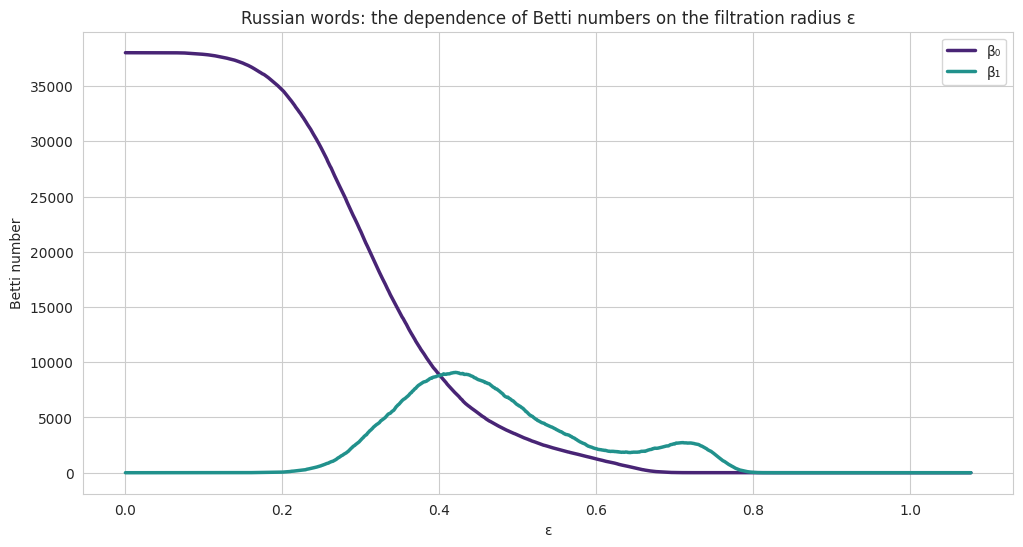

In [ ]:
betti_plot("holes", "Russian words")

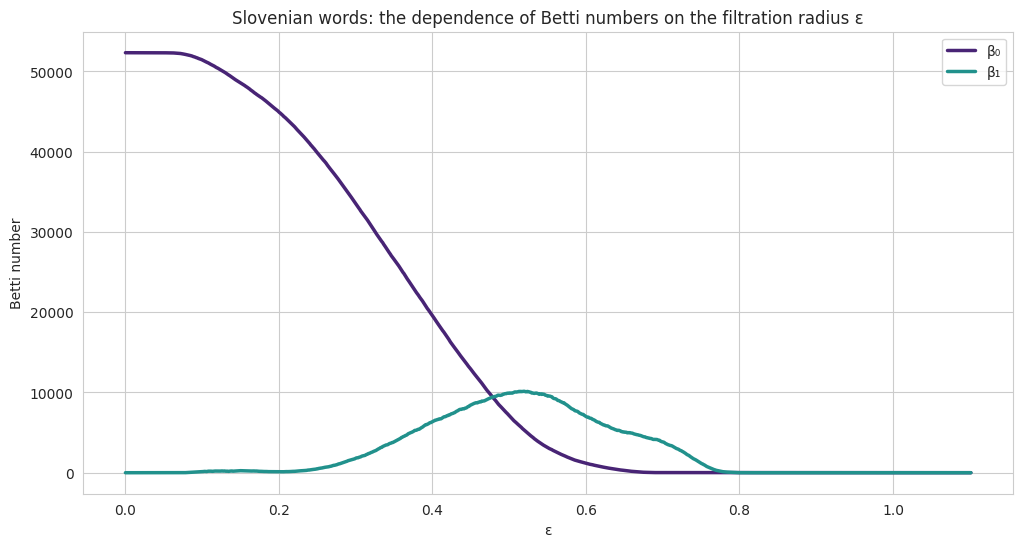

In [ ]:
betti_plot("holes", "Slovenian words")

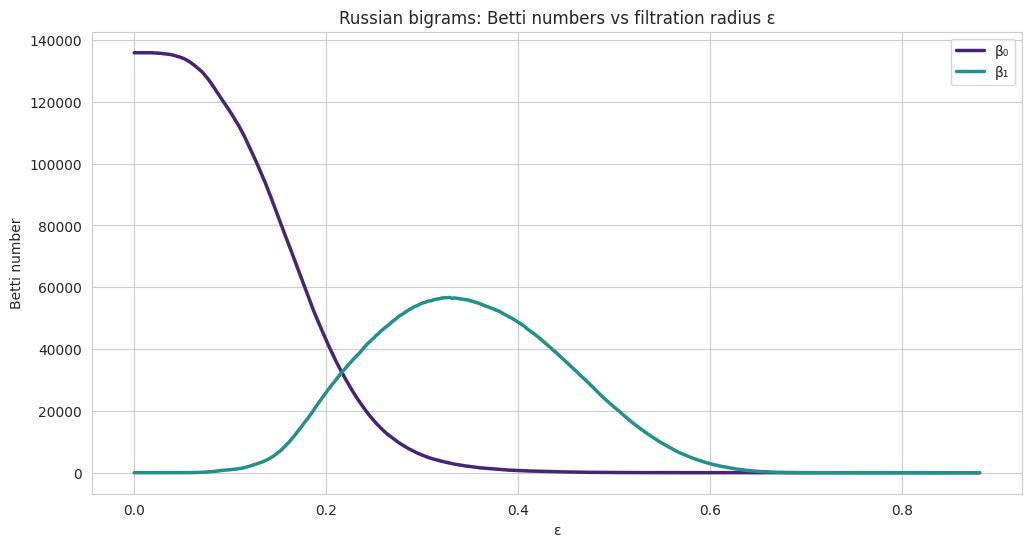

In [ ]:
betti_plot("holes", "Russian bigrams")

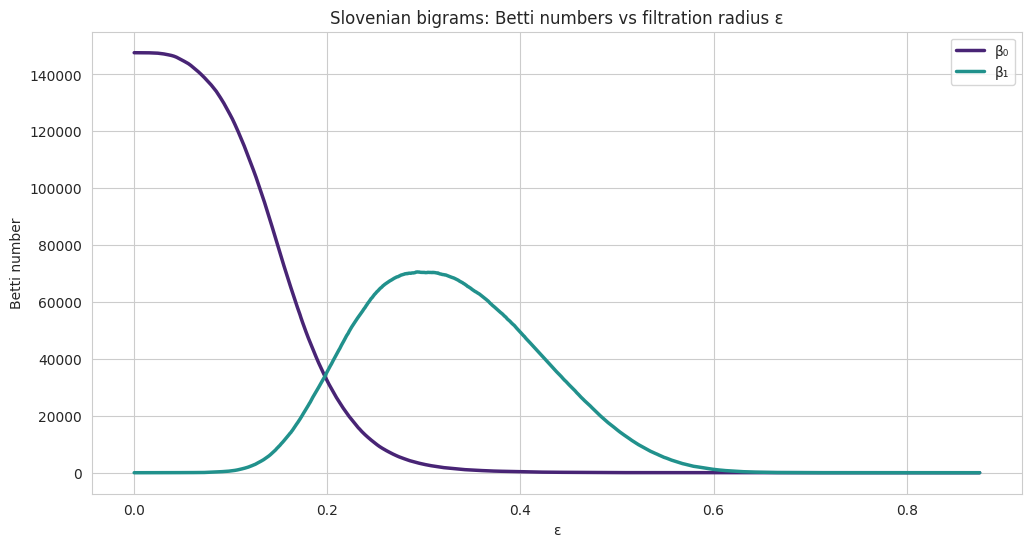

In [ ]:
betti_plot("holes", "Slovenian bigrams")